# Lab Seven: Sequential Networks
#### By: Abhilash Arnipalli

##  <ins>Business Understanding</ins>
##### The goal of this report is to predict tweet sentiment by implementing sequential network architectures and tuning their hyper-parameters. 
I collected data from the [Sentiment140 dataset](https://www.kaggle.com/datasets/kazanova/sentiment140?resource=download) which is a dataset that consists of 1.6 million tweets annotated with sentiment labels (0 = negative, 2 = neutral, 4 = positive). The purpose of collecting this data was to create a labeled dataset for sentiment analysis and to detect and understand the sentiment expressed in tweets. The data was extracted using the Twitter API and each tweet is associated with various attributes like polarity, timestamp, user, and text content. The prediction task for this dataset is sentiment classification, where my goal is to predict the sentiment polarity of a tweet as either negative, neutral, or positive. The sentiment prediction algorithm needs to perform with a high level of accuracy to be optimal, meaning my sentiment analysis model would need to accurately capture the sentiment expressed in tweets and determine if they are positive or negative.

##### Import Necessary Packages:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.models import Sequential

#  <ins>Data Preparation</ins>

- I load the Sentiment140 dataset into a pandas dataframe.
- I then perform a calculation to determine the total number of words in each tweet. This helps me understand the length and complexity of the text data.
- I then narrow down the dataset by selecting only the **`sentiment`** and **`text`** columns which are the two key components for sentiment analysis and rename them accordingly.
- I also modify the sentiment labels by replacing 4 with 1 in the **`sentiment`** column to make it binary (0 for negative, 1 for positive).

In [2]:
data = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding="ISO-8859-1", header=None)
data = data[[0,5]]
data.columns = ["sentiment", "text"]
data["sentiment"] = data["sentiment"].replace(4, 1)

In [3]:
data["word_count"] = data["text"].apply(lambda x: len(x.split()))

### Word Count Visualization:

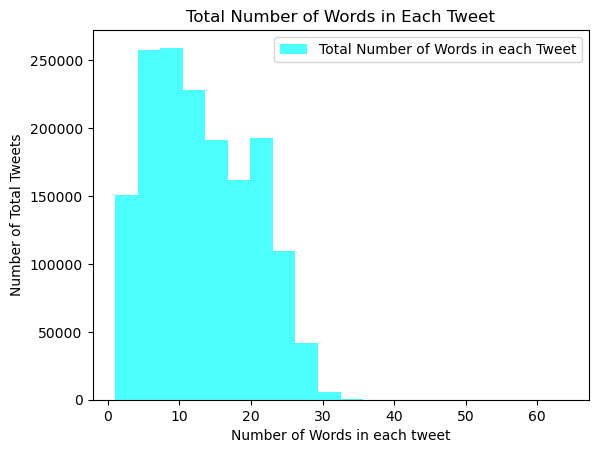

In [4]:
plt.hist(data["word_count"], bins=20, color='cyan', alpha=0.7, label='Total Number of Words in each Tweet')
plt.title("Total Number of Words in Each Tweet")
plt.xlabel("Number of Words in Each Tweet")
plt.ylabel("Number of Total Tweets")
plt.legend()
plt.show()

In [ ]:
# Calculate the count of each unique value in the "word_count" column and sort the counts based on the index (number of words in each tweet)
word_count_counts = data["word_count"].value_counts().sort_index()

# Plot the total number of words in each tweet
plt.plot(word_count_counts, color='purple', label='Total Number of Words in each Tweet')
plt.axvline(x=word_count_counts.idxmax(), color='red', linestyle='--', label='Most Number of Words in a Tweet')
plt.title("Total Number of Words in Each Tweet")
plt.xlabel("Number of Words in Each Tweet")
plt.ylabel("Number of Total Tweets")
plt.legend()
plt.show()

# Drop the "word_count" column from the DataFrame
data.drop("word_count", axis=1, inplace=True)

From the two visualizations above, I notice that most of the tweets have a low amount of characters with most of them around _____________ characters. I also see that none of the tweets have more than 30 words which may be due to Twitter's 30 word max length per tweet requirement. Because of this, I will use 30 word length sequences when I create my models.

### Metric for Evaluating Algorithm Performance

Balanced Accuracy is the appropriate metric to use on this dataset because my dataset is balanced. My models will be used to analyze sentiment for specific topics on twitter and accuracy can be used to evaluate the performance of classification for that task. Balanced Accuracy is also a good metric because since the tweets have been annotated 0 for negative and 4 for positive and they can be used to detect sentiment, I have to care equally about true positives or true negatives in regards to false positives and false negatives. Therefore, balanced accuracy would be the appropriate metric for doing so. Balanced Accuracy is also the most commonly used metric when it comes to sentiment analysis tasks and would be appropriate in this case.

#### Why?
1) Handling Class Imbalance:
Because I am dealing with sentiment analysis, using Balanced Accuracy will help me consider the performance on both classes and it provides a reliable measure for balanced classes.

2) Equal Weighting of Classes:
Balanced Accuracy also takes the true positive rate and true negative rate. This means that both positive and negative sentiments contribute equally to the overall performance of the Model. In regards to sentiment analysis, my goal is often to be equally sensitive to both positive and negative sentiments. 

3) Reflecting Real-world Performance:
Sentiment analysis models (when being used in the real world) are usually deployed to understand a form of public opinion. By using solely accuracy, I could achieve high accuracy on predicting one sentiment class while performing poorly on the other and it could lead to incomplete insights. Balanced Accuracy on the other hand will give me a more comprehensive measure of the model's overall ability to capture sentiments from both perspectives.

##### Sentiment Count of Each Class:

In [6]:
print("Sentiment Count:")
data.sentiment.value_counts()

Sentiment Count:


sentiment
0    800000
1    800000
Name: count, dtype: int64

### Method for Dividing Data
My dataset will be split into training and testing sets using an 80-20 train-test split. From the Sentiment Count shown above, I can see that my dataset has 1.6M tweets split evently between two classes (positive and negative) so it is easily large enough to train and test each with.

#### Why?
1) The 80-20 train-test split provides me with a realistic scenario where my model needs to be trained on a subset of the data and then tested on an independent subset. In real-world scenarios, machine learning models are trained on historical data and deployed to make predictions on new, unseen data. The 80-20 split simulates this process by reserving a portion of the dataset (20%) for testing, which represents new, unseen data and it makes sure that my model is evaluated on data that it has never seen during training.


2) With 1.6 million tweets in the dataset, an 80-20 split results in a substantial amount of data for training (1.28 million tweets) while still leaving a sizable portion for testing (320,000 tweets). Having sufficient training data is needed for training my models and identifying the underlying patterns in the data.


3) The dataset's sentiment classes are also balanced, with 800,000 samples for each class. The train-test split preserves this balance in both the training and testing sets. This makes sure that the model is exposed to an equal representation of positive and negative sentiments during training which will help avoid potential biases that can be introduced by imbalanced class distributions.

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data["text"], data["sentiment"], test_size=0.2, random_state=42)

### Methods of Tokenization
1) **Tokenizer Initialization:** The Tokenizer class is initializing, and the `fit_on_texts` method is used to update the internal vocabulary based on the training text data (X_train in this case).

2) **Texts to Sequences Conversion:** The `texts_to_sequences` method is applied to both the training and testing text data, converting each tweet's text into a sequence of integers based on the vocabulary created during the fitting process.

3) **Word Index:** The `word_index` attribute of the tokenizer is then used to obtain a dictionary mapping words to their corresponding integers in the vocabulary.

In [8]:
# Initialize a Tokenizer object
tokenizer = Tokenizer()

# Fit the tokenizer on the training data to create a vocabulary
tokenizer.fit_on_texts(X_train)

# Convert the text sequences in the training set to numerical sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)

# Convert the text sequences in the test set to numerical sequences using the same tokenizer
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Get the word index mapping from words to numerical indices
word_index = tokenizer.word_index

# Print the number of unique tokens found in the training data
print('Number of Unique Tokens Found: %s' % (len(word_index)))

Number of Unique Tokens Found: 594848


4) **Embedding:** Next, I create an embedding layer for my models using the [**GloVe (Twitter version)**](https://github.com/stanfordnlp/GloVe.git) word embeddings. I load pre-trained GloVe word embeddings and match them to the words in the dataset and create an embedding matrix. The embedding layer is non-trainable and its weights are initialized with pre-trained word vectors. The embedding matrix information is then printed below.

In [9]:
%%time

# Set the embedding size to 200
EMBED_SIZE = 200
# Initialize an empty dictionary to store word vectors from the GloVe embeddings
embeddings_index = {}

# Open the GloVe pre-trained word embeddings file
f = open('glove.twitter.27B.200d.txt')
# Loop through each line in the GloVe file
for line in f:
    # Split each line into a list of values
    values = line.split()
    # Extract the word from the first value
    word = values[0]
    # Convert the remaining values to a NumPy array representing the word vector
    coefs = np.asarray(values[1:], dtype='float32')
    # Store the word vector in the embeddings_index dictionary
    embeddings_index[word] = coefs
# Close the GloVe file
f.close()

# Print the total number of word vectors found in the GloVe embeddings
print('Number Of Word Vectors Found %s word vectors:' % len(embeddings_index))

# Initialize counters for found words
found_words = 0
# Initialize an embedding matrix with zeros
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
# Loop through each word and its index in the word_index dictionary
for word, i in word_index.items():
    # Get the word vector from the embeddings_index if available
    embedding_vector = embeddings_index.get(word)
    # If the word vector is found, update the embedding matrix
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        found_words = found_words + 1

# Print information about the embedding matrix
print("Embedding Layer Shape:", embedding_matrix.shape, "\n", "Total Number of Words Found:", found_words, "\n", "Percentage:", 100 * found_words / embedding_matrix.shape[0])

Number Of Word Vectors Found 1193514 word vectors:
Embedding Layer Shape: (594849, 200) 
 Total Number of Words Found: 121078 
 Percentage: 20.35440927025178
CPU times: user 23.5 s, sys: 816 ms, total: 24.4 s
Wall time: 24.3 s


5) **Padding Sequences:** Now, the decision to force a specific length of sequence is made. The `pad_sequences` function is applied to both the training and testing sequences, ensuring that all sequences have a fixed length of 30. Sequences longer than 30 words are truncated, while shorter sequences are padded with zeros.

In [10]:
X_train = pad_sequences(X_train_sequences, maxlen=30)
X_test = pad_sequences(X_test_sequences, maxlen=30)

In [11]:
MAX_ART_LEN = 30

#save the embedding layer
embedding_layer = Embedding(len(word_index) + 1, EMBED_SIZE, weights=[embedding_matrix], input_length=MAX_ART_LEN, trainable=False)

After Data Preparation, the final dataset used for sentiment analysis is based on the original Sentiment140 dataset. The original dataset consists of 1.6 million tweets, each annotated with sentiment labels (0 = negative, 2 = neutral, 4 = positive). In the new dataset after preparation, only the columns related to sentiment and text content are retained (all others are dropped). The sentiment column is then modified to have binary labels (0 for negative and 1 for positive). The dataset is then split into training and testing sets using an 80-20 train-test split with the embedding layer and padding sequences added.


# <ins>Modeling</ins>

## Recurrent Neural Network (RNN)
* Now I will create two Recurrent Neural Network (RNN) models: **RNN 1 and RNN 2**.
* **RNN 1** has a simple architecture with one LSTM layer.
* **RNN 2** includes a dropout layer to prevent overfitting.
* Both models are trained and their loss over epochs is visualized below.

##### Define a `plot_history` function for visualizations made later on

In [12]:
import matplotlib.pyplot as plt

# Define a plot_history function for visualizations made below
def plot_history(history):
    # plot history of the model:
    fig = plt.figure(figsize=(10, 8))
    plt.plot(history.history['loss'], label='train', color='purple')
    plt.plot(history.history['val_loss'], label='validate', color='cyan')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs History')

## RNN 1

In [13]:
# Create a Sequential model for RNN1
rnn1 = Sequential()

# Add the embedding layer to the model
rnn1.add(embedding_layer)

# Add an LSTM layer with 100 units to the model
rnn1.add(LSTM(100))

# Add a Dense layer with a sigmoid activation function to output binary classification (1 neuron)
rnn1.add(Dense(1, activation='sigmoid'))

# Compile the model using binary cross-entropy loss, Adam optimizer, and accuracy as a metric
rnn1.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

# Display a summary of the model architecture
rnn1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 200)           118969800 
                                                                 
 lstm (LSTM)                 (None, 100)               120400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 119090301 (454.29 MB)
Trainable params: 120501 (470.71 KB)
Non-trainable params: 118969800 (453.83 MB)
_________________________________________________________________


### RNN 1 Loss Over Epochs History

In [14]:
# Train the RNN1 model on the training data
# X_train: Training input sequences
# y_train: Training labels (sentiment: 0 or 1)
# epochs: Number of times the entire training dataset is passed forward and backward through the neural network
# validation_data: Tuple of validation input sequences and labels to monitor model performance on a separate validation set
# batch_size: Number of samples processed in each batch during training
history_rnn_1 = rnn1.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=2048)

Epoch 1/20
625/625 [==============================] - 171s 273ms/step - loss: 0.4560 - accuracy: 0.7830 - val_loss: 0.4232 - val_accuracy: 0.8037
Epoch 2/20
625/625 [==============================] - 169s 271ms/step - loss: 0.4126 - accuracy: 0.8101 - val_loss: 0.4096 - val_accuracy: 0.8108
Epoch 3/20
625/625 [==============================] - 168s 269ms/step - loss: 0.3975 - accuracy: 0.8185 - val_loss: 0.3964 - val_accuracy: 0.8189
Epoch 4/20
625/625 [==============================] - 168s 269ms/step - loss: 0.3879 - accuracy: 0.8239 - val_loss: 0.3917 - val_accuracy: 0.8214
Epoch 5/20
625/625 [==============================] - 169s 270ms/step - loss: 0.3801 - accuracy: 0.8281 - val_loss: 0.3872 - val_accuracy: 0.8241
Epoch 6/20
625/625 [==============================] - 171s 274ms/step - loss: 0.3739 - accuracy: 0.8315 - val_loss: 0.3859 - val_accuracy: 0.8251
Epoch 7/20
625/625 [==============================] - 173s 276ms/step - loss: 0.3686 - accuracy: 0.8343 - val_loss: 0.3821 -

### RNN 1 Loss Over Epochs Visualization

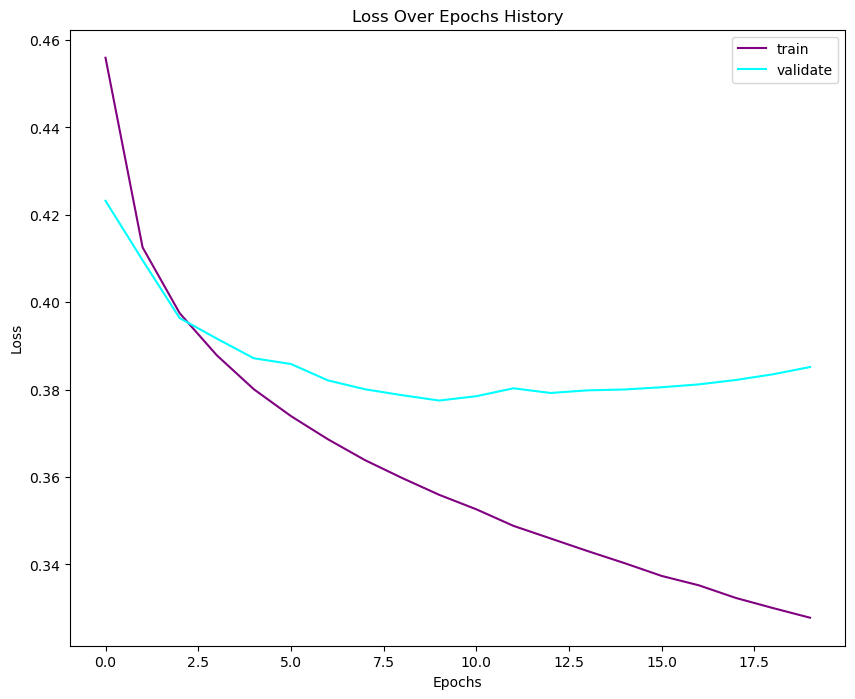

In [15]:
# plot the loss over epochs history
plot_history(history_rnn_1)

From the visualization above I can see that **RNN 1** exhibits a clear convergence around 12 epochs. After 12 epochs, the training accuracy steadily increases, indicating that the model is effectively learning from the training data. The validation accuracy also experiences a consistent improvement over epochs. The final validation accuracy is at around 82.93%. This accuracy metric is an indication of my model's performance on real-world data and aligns with my objective of sentiment classification. The visualization of **RNN 1's** convergence shows my model's ability to capture patterns in sentiment data and a validation accuracy of 82.93% indicates that it is pretty accurate.

### Hyper-Parameter Adjustment
I now include dropout to try and potentially mitigate the overfitting that is occurring in **RNN 1** and improve the generalization performance of **RNN 2** below.

## RNN 2

In [16]:
rnn2 = Sequential()
rnn2.add(embedding_layer)

# Add an LSTM layer with 100 units, incorporating dropout for regularization
# recurrent_dropout is applied to the recurrent state connections
rnn2.add(LSTM(100, dropout=0.2, recurrent_dropout = 0.2))
rnn2.add(Dense(1, activation='sigmoid'))
rnn2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 200)           118969800 
                                                                 
 lstm_1 (LSTM)               (None, 100)               120400    
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 119090301 (454.29 MB)
Trainable params: 120501 (470.71 KB)
Non-trainable params: 118969800 (453.83 MB)
_________________________________________________________________


### RNN 2 Loss Over Epochs History

In [17]:
history_rnn_2 = rnn2.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), batch_size=2048)

Epoch 1/30
625/625 [==============================] - 183s 292ms/step - loss: 0.4672 - accuracy: 0.7761 - val_loss: 0.4281 - val_accuracy: 0.8006
Epoch 2/30
625/625 [==============================] - 184s 295ms/step - loss: 0.4270 - accuracy: 0.8013 - val_loss: 0.4097 - val_accuracy: 0.8114
Epoch 3/30
625/625 [==============================] - 185s 295ms/step - loss: 0.4132 - accuracy: 0.8094 - val_loss: 0.4003 - val_accuracy: 0.8162
Epoch 4/30
625/625 [==============================] - 184s 295ms/step - loss: 0.4049 - accuracy: 0.8141 - val_loss: 0.3948 - val_accuracy: 0.8200
Epoch 5/30
625/625 [==============================] - 184s 294ms/step - loss: 0.3987 - accuracy: 0.8177 - val_loss: 0.3906 - val_accuracy: 0.8221
Epoch 6/30
625/625 [==============================] - 183s 293ms/step - loss: 0.3942 - accuracy: 0.8200 - val_loss: 0.3899 - val_accuracy: 0.8232
Epoch 7/30
625/625 [==============================] - 185s 296ms/step - loss: 0.3902 - accuracy: 0.8226 - val_loss: 0.3847 -

### RNN 2 Loss Over Epoch Visualization

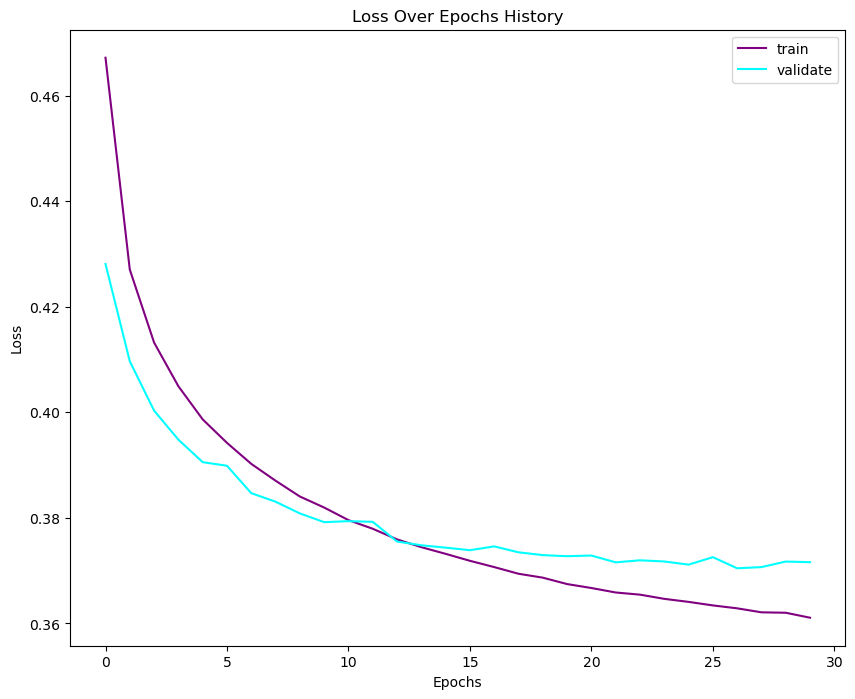

In [18]:
plot_history(history_rnn_2)

From the visualization above, I can see that the introduction of dropout has a notable effect on overfitting during training. With dropout integrated, the training accuracy of **RNN 2** continues to improve as the model learns and it plateaus around 24 epochs. This suggests that further training may not significantly enhance the model's performance on the training set. The validation accuracy exhibits a similar trend. The inclusion of dropout now gives me a validation accuracy of about 83.48%, which is a notable increase from the validation accuracy of **RNN 1**. 

### Comparing RNN 1 and RNN 2
Now, my predictions from both Models are rounded to binary values and I perform McNemar's test to statistically compare the performance of **RNN 1** and **RNN 2**.

In [19]:
# Make predictions using the RNN1 and RNN2 models on the test data
y_pred_rnn1 = rnn1.predict(X_test)
y_pred_rnn2 = rnn2.predict(X_test)

# Round the predicted probabilities to obtain binary predictions (0 or 1)
y_pred_rnn1 = np.round(y_pred_rnn1.reshape(-1))
y_pred_rnn2 = np.round(y_pred_rnn2.reshape(-1))

# Count the number of correct predictions for each model
# y_test: True labels (sentiment: 0 or 1)
y_pred_rnn1_correct = np.sum((y_pred_rnn1 == y_test) & (y_pred_rnn2 != y_test))
y_pred_rnn2_correct = np.sum((y_pred_rnn2 == y_test) & (y_pred_rnn1 != y_test))

# Calculate the critical value for the McNemar test
critical_value = (y_pred_rnn1_correct + y_pred_rnn2_correct)**2 / (y_pred_rnn1_correct + y_pred_rnn2_correct)

from scipy.stats import chi2
import math

# Calculate the p-value using the Chi-squared distribution
p_value = 1 - chi2.cdf(math.sqrt(critical_value), 1)

# Print the p-value
print("P-Value:", p_value)

10000/10000 [==============================] - 75s 7ms/step
P-Value: 0.0


With the P-value above, I can confidently reject the null hypothesis. This value is evidence to show that there is a difference in the predictive performance of both models **RNN 1** and **RNN 2** on the test data. The P-value also shows that one model outperforms the other in the binary classification task with **RNN 2** being the better one.

## Convolutional Neural Network (CNN)
* Now, I create two Convolutional Neural Network models (**CNN 1** and **CNN 2**).
* **CNN 1** is a CNN model with 1D convolutions.
* The model is trained and its loss over epochs is visualized below.
* The sequence is then transformed into a 2x15 array for a different CNN architecture (**CNN 2**).

## CNN 1

In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import Embedding

EMBED_SIZE = 200 #embedding size
sequence_input = Input(shape=(MAX_ART_LEN,), dtype='int32')
# starting size: 30

embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv1D(256, 3, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)
x = Dropout(0.15)(x)
x = Conv1D(256, 3, activation='relu',
           kernel_initializer='he_uniform')(x)


x = Dropout(0.2)(x)
x = Conv1D(256, 3, activation='relu',
           kernel_initializer='he_uniform')(x)

x = MaxPooling1D(24)(x)
x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation='relu',
          kernel_initializer='he_uniform')(x)

preds = Dense(1, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)
opt = keras.optimizers.Nadam()
cnn1 = Model(sequence_input, preds)
cnn1.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['acc'])

print(cnn1.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 200)           118969800 
                                                                 
 conv1d_9 (Conv1D)           (None, 28, 256)           153856    
                                                                 
 dropout_9 (Dropout)         (None, 28, 256)           0         
                                                                 
 conv1d_10 (Conv1D)          (None, 26, 256)           196864    
                                                                 
 dropout_10 (Dropout)        (None, 26, 256)           0         
                                                                 
 conv1d_11 (Conv1D)          (None, 24, 256)           1968

### CNN 1 Loss Over Epoch History

In [27]:
cnn_hist = cnn1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=2048)

Epoch 1/20
625/625 [==============================] - 411s 657ms/step - loss: 0.4731 - acc: 0.7714 - val_loss: 0.4230 - val_acc: 0.8060
Epoch 2/20
625/625 [==============================] - 410s 656ms/step - loss: 0.4167 - acc: 0.8080 - val_loss: 0.4066 - val_acc: 0.8158
Epoch 3/20
625/625 [==============================] - 408s 653ms/step - loss: 0.4008 - acc: 0.8171 - val_loss: 0.3948 - val_acc: 0.8211
Epoch 4/20
625/625 [==============================] - 407s 652ms/step - loss: 0.3908 - acc: 0.8231 - val_loss: 0.3912 - val_acc: 0.8237
Epoch 5/20
625/625 [==============================] - 406s 650ms/step - loss: 0.3830 - acc: 0.8270 - val_loss: 0.3867 - val_acc: 0.8260
Epoch 6/20
625/625 [==============================] - 406s 650ms/step - loss: 0.3762 - acc: 0.8304 - val_loss: 0.3852 - val_acc: 0.8263
Epoch 7/20
625/625 [==============================] - 406s 650ms/step - loss: 0.3708 - acc: 0.8333 - val_loss: 0.3858 - val_acc: 0.8266
Epoch 8/20
625/625 [============================

### CNN 1 Loss Over Epoch Visualization

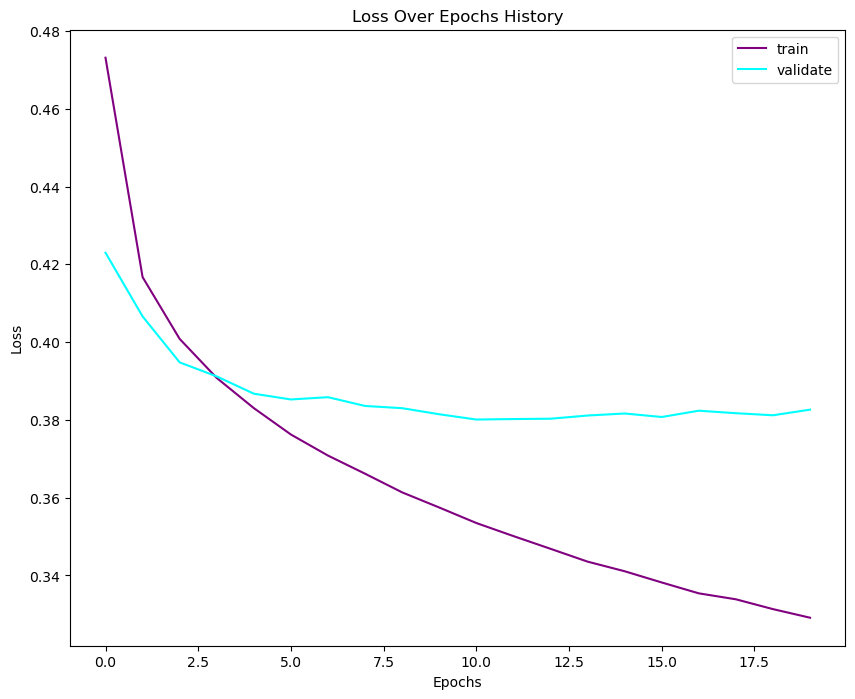

In [28]:
plot_history(cnn_hist)

From the visualization above, I can see that the validation loss curve plateaus around 7.5 epochs which suggests that further training might not lead to significant improvements in the model's ability to generalize unseen data.  The validation accuracy reaches around 82.82%. This accuracy level shows that the model is still efficient and accurate. With convergence being around 7.5, I know that CNN 1 effectively learns relevant features from the data and achieves a satisfactory level of generalization. The visualization of CNN 1's convergence gives me a detailed view of its learning dynamics. 

### Hyper-Parameter Adjustment
Now, I will reshape the sequence into a 2x15 array and use 2D convolutions to related close words in the sequence and words in the opposite half of the sequence.

In [29]:
# Reshape the training data (X_train) into a 2D array with dimensions (1280000, 15, 2)
x2d = X_train.reshape(1280000, 15 , 2)

# Display the new shape of the training data
print("Training Data New Dimensions:")
x2d.shape

Training Data New Dimensions:


(1280000, 15, 2)

In [30]:
# Display the original shape of the training data
print("Training Data Original Dimensions:")
X_train.shape

Training Data Original Dimensions:


(1280000, 30)

In [31]:
# Reshape the testing data (X_test) into a 2D array with dimensions (320000, 15, 2)
x2d_test = X_test.reshape(320000, 15 , 2)

# Display the new shape of the training data
print("Training Data New Shape:")
x2d_test.shape

Training Data New Shape:


(320000, 15, 2)

## CNN 2

In [34]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAvgPool2D
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import Embedding



EMBED_SIZE = 200 #embedding size
sequence_input = Input(shape=(15,2), dtype='int32')
# starting size: 30

embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv2D(512, (1, 2), activation='relu',
           kernel_initializer='he_uniform', padding="same")(embedded_sequences)
x = Dropout(0.15)(x)
x = Conv2D(512, (2,2), activation='relu',
           kernel_initializer='he_uniform', padding="same")(x)


x = Dropout(0.2)(x)
x = Conv2D(512, (2, 5), activation='relu',
           kernel_initializer='he_uniform', padding="same")(x)
x = GlobalAvgPool2D()(x)
x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu',
          kernel_initializer='he_uniform')(x)

preds = Dense(1, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)
opt = keras.optimizers.Nadam()
cnn2 = Model(sequence_input, preds)
cnn2.compile(loss='mse',
              optimizer=opt,
              metrics=['acc'])

print(cnn2.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 15, 2)]           0         
                                                                 
 embedding (Embedding)       multiple                  118969800 
                                                                 
 conv2d_3 (Conv2D)           (None, 15, 2, 512)        205312    
                                                                 
 dropout_15 (Dropout)        (None, 15, 2, 512)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 15, 2, 512)        1049088   
                                                                 
 dropout_16 (Dropout)        (None, 15, 2, 512)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 15, 2, 512)        2621

### CNN 2 Loss Over Epoch History

In [35]:
cnn2_hist = cnn2.fit(x2d, y_train, validation_data=(x2d_test, y_test),epochs=15, batch_size=2048)

Epoch 1/15
625/625 [==============================] - 4626s 7s/step - loss: 0.1484 - acc: 0.7840 - val_loss: 0.1339 - val_acc: 0.8081
Epoch 2/15
625/625 [==============================] - 4621s 7s/step - loss: 0.1290 - acc: 0.8166 - val_loss: 0.1257 - val_acc: 0.8213
Epoch 3/15
625/625 [==============================] - 4643s 7s/step - loss: 0.1230 - acc: 0.8265 - val_loss: 0.1230 - val_acc: 0.8253
Epoch 4/15
625/625 [==============================] - 4649s 7s/step - loss: 0.1189 - acc: 0.8326 - val_loss: 0.1226 - val_acc: 0.8259
Epoch 5/15
625/625 [==============================] - 4622s 7s/step - loss: 0.1152 - acc: 0.8392 - val_loss: 0.1206 - val_acc: 0.8294
Epoch 6/15
625/625 [==============================] - 4625s 7s/step - loss: 0.1121 - acc: 0.8443 - val_loss: 0.1200 - val_acc: 0.8300
Epoch 7/15
625/625 [==============================] - 4597s 7s/step - loss: 0.1089 - acc: 0.8497 - val_loss: 0.1205 - val_acc: 0.8294
Epoch 8/15
625/625 [==============================] - 4599s 7s

### CNN 2 Loss Over Epoch Visualization

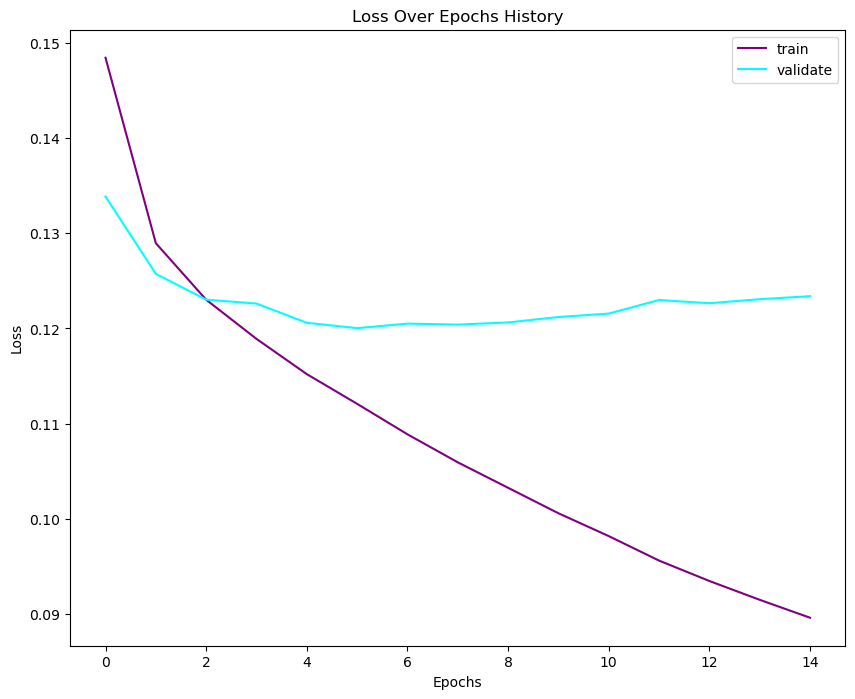

In [36]:
plot_history(cnn2_hist)

From the visualization above, I can see that CNN 2 converges around 8 epochs showing me that it performs classification well. However, there is a slight decline in performance after the convergence point which may be due to potential overfitting. Although a decline occurs, the model still achieves an efficient validation accuracy of about 82.93%. 8 epochs for convergence aligns with the observed behavior in the training and validation accuracies as well as the model's learning dynamics. The visualization of CNN 2's convergence shows me that the model still has the ability to effectively learn sentiment-related features from the dataset. 

### Comparing CNN 1 and CNN 2
Now, I perform McNemar's test to statistically compare the performance of CNN 1 and CNN 2.

In [37]:
y_pred_cnn1 = cnn1.predict(X_test)
y_pred_cnn2 = cnn2.predict(x2d_test)

y_pred_cnn1 = np.round(y_pred_cnn1.reshape(-1))
y_pred_cnn2 = np.round(y_pred_cnn2.reshape(-1))

y_pred_cnn1_correct = np.sum((y_pred_cnn1 == y_test) & (y_pred_cnn2 != y_test))
y_pred_cnn2_correct = np.sum((y_pred_cnn2 == y_test) & (y_pred_cnn1 != y_test))

critical_value = (y_pred_cnn1_correct + y_pred_cnn2_correct)**2 / (y_pred_cnn1_correct + y_pred_cnn2_correct)
from scipy.stats import chi2
import math

p_value = 1 - chi2.cdf(math.sqrt(critical_value), 1)
print("P-value: ", p_value)

10000/10000 [==============================] - 273s 27ms/step
P-value:  0.0


Based on the P-value above, I can confidently conclude that the models are not the same and reject the null hypothesis that the two CNN's are not different based on the Mcnemar test conducted. CNN 1 can be seen achieving a validation accuracy of 82.82% and the CNN 2 can be seen achieving a validation accuracy of 83.08%, proving that CNN 2 is the slightly better Model.

## Comparing my Two Best Models
Now I perform McNemar's test to determine which Model is the most efficient. To do this I statistically compare my best RNN model (RNN 2) with my best CNN model (CNN 2).

In [38]:
y_pred_rnn2 = rnn2.predict(X_test)
y_pred_cnn2 = cnn2.predict(x2d_test)

y_pred_rnn2 = np.round(y_pred_rnn2.reshape(-1))
y_pred_cnn2 = np.round(y_pred_cnn2.reshape(-1))

y_pred_rnn2_correct = np.sum((y_pred_rnn2 == y_test) & (y_pred_cnn2 != y_test))
y_pred_cnn2_correct = np.sum((y_pred_cnn2 == y_test) & (y_pred_rnn2 != y_test))

critical_value = (y_pred_rnn2_correct + y_pred_cnn2_correct)**2 / (y_pred_rnn2_correct + y_pred_cnn2_correct)
from scipy.stats import chi2
import math

p_value = 1 - chi2.cdf(math.sqrt(critical_value), 1)
print("P-value: ", p_value)

10000/10000 [==============================] - 275s 28ms/step
P-value:  0.0


The McNemar test above gives me a P-value of 0. Therefore, I can confidently conclude that the models are drastically different and I can reject the null hypothesis that the models are the same and that RNN 2 is the most efficient Model.
## Conclusion
My analysis of the various models that I created for sentiment analysis on the Sentiment140 dataset leads me to believe that RNN 2 is the optimal model. I base this conclusion on the validation accuracy metric which is a key indicator of my model's ability to generalize unseen data. RNN 2 is a recurrent neural network where I included dropout to help with the overfitting occurring in RNN 1. It showed superior performance by achieving a validation accuracy of 83.48% which was better than any of the other models. 

I chose balannced accuracy as the evaluation metric due to the balanced nature of my dataset and because my goal was to classify tweets into binary sentiment categories (positive or negative). The statistical significance of the model comparison was created using the McNemar test and it revealed a p-value of 0. This gave me the evidence I need to reject the null hypothesis and it indicates a difference in predictive performance between RNN 2 and the other models, especially in comparison to CNN 1 and RNN 1. The validation accuracy of 83.48% reflects RNN 2's ability to effectively recognize patterns in tweet data and perform accurate sentiment classification based on this. Therefore, I can conclude that RNN 2 is the most optimal model for my sentiment analysis task.

# <ins>Additional Analysis</ins>

## ConceptNet vs GloVe Embedding
I will now use the pre-trained ConceptNet Numberbatch embedding and compare to the pre-trained GloVe embedding to determine which method is better for my goal of sentiment analysis.

In [39]:
# Load ConceptNet Numberbatch embeddings
conceptnet_embeddings_path = 'numberbatch-19.08.txt'  

# Function to load ConceptNet embeddings
def load_conceptnet_embeddings(embeddings_path):
    embeddings_index = {}
    with open(embeddings_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Load ConceptNet embeddings
conceptnet_embeddings = load_conceptnet_embeddings(conceptnet_embeddings_path)

# Create ConceptNet embedding matrix
embedding_matrix_conceptnet = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = conceptnet_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix_conceptnet[i] = embedding_vector

# Modify the Embedding Layer in your models
embedding_layer_conceptnet = Embedding(len(word_index) + 1,
                                       EMBED_SIZE,
                                       weights=[embedding_matrix_conceptnet],
                                       input_length=MAX_ART_LEN,
                                       trainable=False)


### Confusion Matrix and Classification Report

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate RNN1
loss_rnn1, acc_rnn1 = rnn1.evaluate(X_test, y_test)
print("RNN1 - Test Loss: {:.4f}, Test Accuracy: {:.4f} \n\n".format(loss_rnn1, acc_rnn1))

# Evaluate RNN2
loss_rnn2, acc_rnn2 = rnn2.evaluate(X_test, y_test)
print("RNN2 - Test Loss: {:.4f}, Test Accuracy: {:.4f} \n\n".format(loss_rnn2, acc_rnn2))

# Evaluate CNN1
loss_cnn1, acc_cnn1 = cnn1.evaluate(X_test, y_test)
print("CNN1 - Test Loss: {:.4f}, Test Accuracy: {:.4f} \n\n".format(loss_cnn1, acc_cnn1))

# Evaluate CNN2
loss_cnn2, acc_cnn2 = cnn2.evaluate(x2d_test, y_test)
print("CNN2 - Test Loss: {:.4f}, Test Accuracy: {:.4f} \n\n".format(loss_cnn2, acc_cnn2))
 

# Confusion Matrix and Classification Report for RNN2
y_pred_rnn2 = rnn2.predict(X_test)
y_pred_rnn2 = np.round(y_pred_rnn2.reshape(-1))
conf_matrix_rnn2 = confusion_matrix(y_test, y_pred_rnn2)
class_report_rnn2 = classification_report(y_test, y_pred_rnn2)

print("Confusion Matrix - RNN2: \n")
print(conf_matrix_rnn2)

print("\nClassification Report - RNN2: \n")
print(class_report_rnn2)

10000/10000 [==============================] - 57s 6ms/step - loss: 0.3852 - accuracy: 0.8288
RNN1 - Test Loss: 0.3852, Test Accuracy: 0.8288 


10000/10000 [==============================] - 61s 6ms/step - loss: 0.3716 - accuracy: 0.8338
RNN2 - Test Loss: 0.3716, Test Accuracy: 0.8338 


10000/10000 [==============================] - 47s 5ms/step - loss: 0.3826 - acc: 0.8279
CNN1 - Test Loss: 0.3826, Test Accuracy: 0.8279 


10000/10000 [==============================] - 274s 27ms/step - loss: 0.1234 - acc: 0.8294
CNN2 - Test Loss: 0.1234, Test Accuracy: 0.8294 


10000/10000 [==============================] - 59s 6ms/step
Confusion Matrix - RNN2: 

[[135147  24347]
 [ 28822 131684]]

Classification Report - RNN2: 

              precision    recall  f1-score   support

           0       0.82      0.85      0.84    159494
           1       0.84      0.82      0.83    160506

    accuracy                           0.83    320000
   macro avg       0.83      0.83      0.83    320000
w

My comparison of the performance of the sentiment analysis models using both the pre-trained ConceptNet Numberbatch and pre-trained GloVe embeddings still show me that RNN 2 achieved the highest accuracy when utilizing the ConceptNet embeddings which is the same as the accuracy achieved with GloVe embeddings. For my specific application of sentiment analysis on the Sentiment140 dataset the pre-trained ConceptNet Numberbatch embeddings perform about the same as the pre-trained GloVe embeddings. In the confusion matrix and classification report above, I can see that for RNN2 with ConceptNet embeddings, I have a balanced precision, recall, and F1-score for both positive and negative sentiments which means both classes perform efficiently. Based on these results I would conclude that the use of ConceptNet Numberbatch embeddings gives about the same accuracy but a more balanced performance across sentiment classes compared to GloVe embeddings.